# Case Study Rekurrente Neuronale Netze: When Taylor meets Helene....

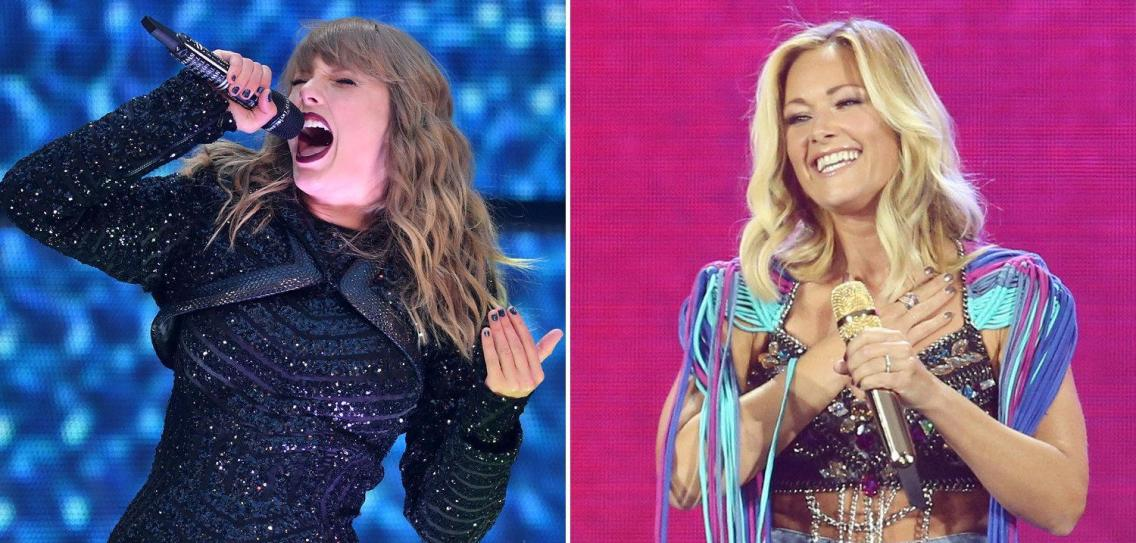

Quelle: Gareth Cattermole/TAS18/Getty Images; Sebastian Willnow/dpa-Zentralbild

Große Teile des Notebooks-Abschnitts Generieren von Text, basiert auf [Link](https://colab.research.google.com/drive/1wlZXZBvOo93pAmTtEUeTlPsgAP4D1bLA#scrollTo=I5EngGk8YuJv), der wiederum Großteile von Karpathy ([Link](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)) übernahm.

Der zweite Teil basiert auf der TensorFlow-Dokumentation.

ACHTUNG: nur bei ausreichender Trainingsdauer ergeben sich später sinnvolle Texte. Die in diesem Notebook eingesetzte Trainingsdauer reicht dafür nicht aus!



## Generieren von Texten mit RNN und LSTM

Es gibt 2 Wege Text zu generieren per RNN:
* auf Basis einzelner Buchstaben
* auf Basis einzelner Wörter.

In diesem Notebook wird der Ansatz über einzelne Buchstaben verwendet. Vorteil ist, daß die Trainingszeiten deutlich(st) kürzer sind als bei der zweiten Methode und daß eine geringere Größe für das Trainieren benötigt wird.

Nachteilig ist jedoch daß nicht so gute Texte herauskommen wie auf Basis von Wörtern, v.a. im Deutschen (da hier durch verschiedene Fälle die Wörter sich deutlich ändern - sogenannte Morpheme).

In [ ]:
# Import libaries
import numpy as np
import pandas as pd
import sys 
import tensorflow as tf

#from tf.keras.models import Sequential
#from tf.keras.models import Sequential
#from tf.keras.layers import LSTM, Activation, Flatten

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed
#from tensorflow.keras.callbacks import ModelCheckpoint
#from tf.keras.utils import np_utils

### 1. Daten organisieren

In [ ]:
!pip install lyricsgenius
import lyricsgenius as lg

client_access_token = "0VWvlXB7n05jSA4MHsae7c0HlznUwVGoRgtFU2d108PSUcp1XvzVe2ZTYzaiOl1o"

genius = lg.Genius(client_access_token,
                   skip_non_songs=True,
                   excluded_terms=["(Remix)", "(Live)"],
                   remove_section_headers=True)

     |████████████████████████████████| 59 kB 4.1 MB/s 


In [ ]:
songs = (genius.search_artist("Taylor Swift",
                              max_songs=100,
                              sort='popularity')).songs

Searching for songs by Taylor Swift...

Song 1: "​cardigan"
Song 2: "​exile"
Song 3: "Lover"
Song 4: "​the 1"
Song 5: "Look What You Made Me Do"
Song 6: "​august"
Song 7: "​betty"
Song 8: "End Game"
Song 9: "You Need To Calm Down"
Song 10: "ME!"
Song 11: "Blank Space"
Song 12: "​champagne problems"
Song 13: "...Ready for It?"
Song 14: "​my tears ricochet"
Song 15: "All Too Well (10 Minute Version) (Taylor’s Version) [From the Vault]"
Song 16: "​willow"
Song 17: "​invisible string"
Song 18: "Cruel Summer"
Song 19: "​the last great american dynasty"
Song 20: "Delicate"
Song 21: "​seven"
Song 22: "Call It What You Want"
Song 23: "Style"
Song 24: "​illicit affairs"
Song 25: "​this is me trying"
"Bad Blood (Remix)" is not valid. Skipping.
"I Don’t Wanna Live Forever" is not valid. Skipping.
Song 26: "Love Story"
Song 27: "​evermore"
Song 28: "All Too Well"
Song 29: "​happiness"
Song 30: "​peace"
Song 31: "Gorgeous"
Song 32: "​mirrorball"
Song 33: "​tolerate it"
Song 34: "​mad woman"
Song 35

In [ ]:
Taylor_Lyrics = ""

for song in songs:
  Taylor_Lyrics += song.lyrics
  Taylor_Lyrics += "\n"

In [ ]:
f = open("TaylorLyrics.txt", "a")
f.write(Taylor_Lyrics)
f.close()

### 2. Daten säubern

Im ersten Schritt der Säuberung entfernen wir alle Satzzeichen, Klammern, :, ;, etc.
Dann werden alle Wörter in KLeinbuchstaben umgewandelt (Python unterscheidet in Groß- und Kleinschreibung).

Dadurch entfernen wir Zeichen, die wir nicht brauchen und reduzieren somit die Komplexität.

In [ ]:
import re

def clean_lyrics(LyricsCollection):
  temp = LyricsCollection

  temp = temp.lower()
  temp = re.sub(r'[0-9]+', ' ', temp) # delete numbers
  # ersetze satzzeichen durch Leerzeichen
  temp = temp.replace('!','')
  temp = temp.replace('?','')
  temp = temp.replace('.',' ') 

  temp = temp.replace('(','')
  temp = temp.replace(')',' ') 
  temp = temp.replace(',','')
  temp = temp.replace(':','')
  temp = temp.replace('-','')
  temp = temp.replace('’',' ')
  temp = temp.replace('“','')
  temp = temp.replace('„',' ')
  temp = temp.replace('…','')
  temp = temp.replace('`',' ')
  temp = temp.replace('\n',' ')
  temp = temp.replace('*',' ')
  temp = temp.replace(';',' ')
  temp = temp.replace('[',' ')
  temp = temp.replace(']',' ')
  temp = temp.replace('，',' ')
  temp = temp.replace('/',' ')
  temp = temp.replace('  ',' ')
  temp = temp.replace('–','')
  temp = temp.replace('‘','')
  temp = temp.replace('´','')
  temp = temp.replace('"', '')
  temp = temp.replace("'", '')

  temp = temp.replace('\x84',' ')
  temp = temp.replace('&',' ')
  temp = temp.replace('\u2005',' ')
  temp = temp.replace('\u205f',' ')

  temp = temp.replace('é','e')
  temp = temp.replace('í','i')
  temp = temp.replace('ó','o')
  temp = temp.replace('\u200b',' ')
  temp = temp.replace('—',' ')
  
  return temp

In [ ]:
Cleaned_Taylor_lyrics = clean_lyrics(Taylor_Lyrics)

In [ ]:
f = open("Cleaned_Taylor_lyrics.txt", "a")
f.write(Taylor_Lyrics)
f.close()

LSTM und andere Neuronale Netze können Text nicht direkt verarbeiten, sondern nur Ziffern. 
Das heißt wir brauchen eine Umwandlung jedes Wort in eine spezifische Nummer (Mapping). Weil wir aber nachher wieder mit den Originalwörtern arbeiten wollen, brauchen wir ein weiteres Mapping zurück.

Das heißt: 
* Wort $\rightarrow$ eindeutige Zahl für Input in Netzwerk
* eindeutige Zahl $\rightarrow$ Wort um den Output des Netzes wieder in ein Wort umwandeln zu können

Um das Netz zusätzlich effizient zu berechnen, löschen wir doppelte Wörter

In [ ]:
TaylorChars = sorted(list(set(Cleaned_Taylor_lyrics)))

int2chars_Taylor = dict((i, c) for i, c in enumerate(TaylorChars))
chars2int_Taylor = dict((i, c) for c, i in enumerate(TaylorChars))

# Auswertungen, wie viele wir erhalten
n_chars_Taylor = len(Cleaned_Taylor_lyrics)
n_vocab_Taylor = len(TaylorChars)

print('Total Characters : ' , n_chars_Taylor) # number of all the characters in lyricsText.txt
print('Total Vocab : ', n_vocab_Taylor) # number of unique characters

print(TaylorChars)

Total Characters :  184076
Total Vocab :  28
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'е']


Zur Veranschaulichung hier wie die Datenstrukturen aussehen:

In [ ]:
print(Cleaned_Taylor_lyrics)

vintage tee brand new phone high heels on cobblestones when you are young they assume you know nothing sequin smile black lipstick sensual politics when you are young they assume you know nothing but i knew you dancin in your levis drunk under a streetlight i i knew you hand under my sweatshirt baby kiss it better i and when i felt like i was an old cardigan under someones bed you put me on and said i was your favorite a friend to all is a friend to none chase two girls lose the one when you are young they assume you know nothing but i knew you playing hideandseek and giving me your weekends i i knew you your heartbeat on the high line once in twenty lifetimes i and when i felt like i was an old cardigan under someones bed you put me on and said i was your favorite to kiss in cars and downtown bars was all we needed you drew stars around my scars but now im bleedin cause i knew you steppin on the last train marked me like a bloodstain i i knew you tried to change the ending peter losin

In [ ]:
print(int2chars_Taylor)

{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'е'}


Würden wir ganze Wörter vorhersagen wollen, würde folgender u.a. Code eingesetzt

In [ ]:
"""
print('Corpus length in characters:', len(Cleaned_Taylor_lyrics))

Taylor_lyrics_in_words = [w for w in Cleaned_Taylor_lyrics.split(' ') if w.strip() != '' or w == '\n']
print('Corpus length in words:', len(Taylor_lyrics_in_words))
"""

"\nprint('Corpus length in characters:', len(Cleaned_Taylor_lyrics))\n\nTaylor_lyrics_in_words = [w for w in Cleaned_Taylor_lyrics.split(' ') if w.strip() != '' or w == '\n']\nprint('Corpus length in words:', len(Taylor_lyrics_in_words))\n"

In [ ]:
"""
# Calculate word frequency
word_freq = {}

for word in Taylor_lyrics_in_words:
    word_freq[word] = word_freq.get(word, 0) + 1  # falls Wort schon vorhanden, dann Zähler um 1 erhöhen

ignored_words = set()
for k, v in word_freq.items():
    if word_freq[k] < MIN_WORD_FREQUENCY:
        ignored_words.add(k)

words = set(Taylor_lyrics_in_words)
print('Unique words before ignoring:', len(words))
print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
words = sorted(set(words) - ignored_words)
print('Unique words after ignoring:', len(words))

word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))
"""

### 3. Daten aufbereiten

In [ ]:
seq_length = 100

Data_X_Taylor = []
Data_y_Taylor = []

for i in range(0, n_chars_Taylor - seq_length, 1):
    # Input sequence(will be used as samples)
    seq_in  = Cleaned_Taylor_lyrics[i:i+seq_length]

    # Output sequence (will be used as target)
    seq_out = Cleaned_Taylor_lyrics[i + seq_length]

    # Store samples in data_X
    Data_X_Taylor.append([chars2int_Taylor[char] for char in seq_in])

    # Store targets in data_y
    Data_y_Taylor.append(chars2int_Taylor[seq_out])

n_patternsTaylor = len(Data_X_Taylor)

print( 'Total Patterns : ', n_patternsTaylor)

Total Patterns :  183976


In [ ]:
# Vektor anpassen damit er in LSTM RNN eingespeist werden kann
X_Taylor = np.reshape(Data_X_Taylor, (n_patternsTaylor, seq_length, 1))

# Normalizing input dat
X_Taylor = X_Taylor/ float(n_vocab_Taylor)

# One hot encode the output targets :
y_Taylor = tf.keras.utils.to_categorical(Data_y_Taylor)

In [ ]:
print(X_Taylor.shape[1], X_Taylor.shape[2])

100 1


Würden wir Wörter vorhersagen, wäre das folgender Code.
Zuerst wollen wir alle Wörter herausfiltern, die nicht häufiger als ein bestimmter Wert vorkommen

In [ ]:
"""
# cut the text in semi-redundant sequences of SEQUENCE_LEN words
STEP = 1
sentences = []
next_words = []
ignored = 0
for i in range(0, len(Taylor_lyrics_in_words) - seq_length, STEP):
    # Only add sequences where no word is in ignored_words
    if len(set(Taylor_lyrics_in_words[i: i+seq_length+1]).intersection(ignored_words)) == 0:
        sentences.append(Taylor_lyrics_in_words[i: i + seq_length])
        next_words.append(Taylor_lyrics_in_words[i + seq_length])
    else:
        ignored = ignored+1
print('Ignored sequences:', ignored)
print('Remaining sequences:', len(sentences))
"""

### 4. Modell erstellen: LSTM

In [ ]:
tf.executing_eagerly()

True

In [ ]:
TaylorModel = tf.keras.Sequential()

TaylorModel.add(tf.keras.layers.LSTM(256, 
                                     input_shape=(X_Taylor.shape[1], X_Taylor.shape[2]), 
                                     return_sequences=True))
TaylorModel.add(tf.keras.layers.Dropout(0.5))

TaylorModel.add(tf.keras.layers.LSTM(256, 
                                     return_sequences=True))
TaylorModel.add(tf.keras.layers.Dropout(0.5))

TaylorModel.add(tf.keras.layers.LSTM(256, 
                                     return_sequences=True))

TaylorModel.add(tf.keras.layers.Dropout(0.5))

TaylorModel.add(tf.keras.layers.LSTM(256, 
                                     return_sequences=True))
TaylorModel.add(tf.keras.layers.Dropout(0.5))

TaylorModel.add(tf.keras.layers.Flatten())

TaylorModel.add(tf.keras.layers.Dense(y_Taylor.shape[1]))

TaylorModel.add(tf.keras.layers.Activation('softmax'))

TaylorModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 256)          264192    
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 256)          525312    
                                                                 
 dropout_1 (Dropout)         (None, 100, 256)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 256)          525312    
                                                                 
 dropout_2 (Dropout)         (None, 100, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 256)         

In [ ]:
model_params = {'epochs': 30,
                'batch_size': 128,
                'callbacks': callbacks_list,
                'verbose': 1,
                'validation_split': 0.2,
                'validation_data': None,
                'shuffle': True,
                'initial_epoch': 0,
                'steps_per_epoch': None,
                'validation_steps': None}

# Configure the checkpoint :
checkpoint_name = 'Weights-LSTM-improvement.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='loss', verbose = 1, save_best_only = True, mode ='min')

callbacks_list = [checkpoint]

TaylorModel.compile(loss='categorical_crossentropy',
                    optimizer="adam")

history = TaylorModel.fit(
      X_Taylor,
      y_Taylor,
      epochs = model_params['epochs'],
      batch_size = model_params['batch_size'],
      callbacks= model_params['callbacks'],
      verbose = model_params['verbose'],
      validation_split = model_params['validation_split'],
      validation_data = model_params['validation_data'],
      shuffle = model_params['shuffle'],
      initial_epoch = model_params['initial_epoch'],
      steps_per_epoch = model_params['steps_per_epoch'],
      validation_steps = model_params['validation_steps']
      )

Epoch 1/30
1150/1150 [==============================] - ETA: 0s - loss: 0.8153
Epoch 00001: loss improved from inf to 0.81530, saving model to Weights-LSTM-improvement.hdf5
1150/1150 [==============================] - 222s 186ms/step - loss: 0.8153 - val_loss: 2.3571
Epoch 2/30
1150/1150 [==============================] - ETA: 0s - loss: 0.8376
Epoch 00002: loss did not improve from 0.81530
1150/1150 [==============================] - 213s 185ms/step - loss: 0.8376 - val_loss: 2.4440
Epoch 3/30
1150/1150 [==============================] - ETA: 0s - loss: 0.8420
Epoch 00003: loss did not improve from 0.81530
1150/1150 [==============================] - 212s 185ms/step - loss: 0.8420 - val_loss: 2.3754
Epoch 4/30
1150/1150 [==============================] - ETA: 0s - loss: 0.8424
Epoch 00004: loss did not improve from 0.81530
1150/1150 [==============================] - 213s 185ms/step - loss: 0.8424 - val_loss: 2.2744
Epoch 5/30
1150/1150 [==============================] - ETA: 0s - los

Laden des Modells ermöglicht uns beim nächsten Mal das Trainieren auszulassen...

In [ ]:
# Load wights file :
wights_file = '/content/Weights-LSTM-improvement.hdf5' # weights file path 
#TaylorModel.load_weights(wights_file)
#TaylorModel.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

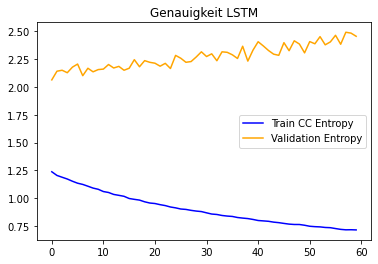

In [ ]:
import matplotlib.pyplot as plt

plt.title('Genauigkeit LSTM')
plt.plot(history.history['categorical_crossentropy'], color='blue', label='Train CC Entropy')
plt.plot(history.history['val_categorical_crossentropy'], color='orange', label='Validation Entropy')
plt.legend()
plt.show()

### Text generieren

Jetzt probieren wir aus, was der TaylorGenerator ausspuckt, wenn wir ihm als Startpunkt das aus dem Attention-Notebook übersetzten Satz "Atemlos durch die Nacht" geben :-)

In [ ]:
# set a random seed :
start = np.random.randint(0, len(Data_X_Taylor)-1)
pattern = Data_X_Taylor[start]
print('Seed : ')
#print("\"",''.join([int2chars_Taylor[value] for value in pattern]), "\"\n")
print("Breathless through the night")

# How many characters you want to generate
generated_characters = 250

# Generate Charachters :
for i in range(generated_characters):
    x = np.reshape(pattern, ( 1, len(pattern), 1))
    x = x / float(n_vocab_Taylor)
    prediction = TaylorModel.predict(x,verbose = 0)
    index = np.argmax(prediction)
    result = int2chars_Taylor[index]
    #seq_in = [int_chars[value] for value in pattern]
    sys.stdout.write(result)

    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print('\nDone')

Seed : 
Breathless through the night
oh ohoh think ooh i dont wanna look that i didnt soun better id think you were ltst conn that i got it shes ne so in the dreams oo the glost and theye was a sasniit line the bomc the sori you the bout of the class she lind and i want io the wordd you
Done


Wie am Anfang erwähnt, benötigen wir für möglichst realistische Texte längere Trainingsdauer...aber man sieht in welche Richtung es geht :-)